# PHASE 2 GROUP 7 PROJECT

## Business Understanding

### Overview
The film industry is a dynamic global market , encompassing all stages of movie creation and distribution, with a powerful cultural and economic influence. As more companies enter the realm of original content, understanding which films resonate most with audiences becomes essential. Analyzing box office trends helps newcomers identify popular genres, profitable themes, and audience preferences, informing smart production choices. This data-driven approach equips new studios to craft engaging content, align with viewer interests, and improve their chances of making a lasting impact in a competitive landscape.

## Business Problem

ABC company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create

## Objectives

1. Identify Popular Film Genres by popularity

2. Identify Emerging Trends and Audience Preferences

3. Identify which type of film are profitable

4. Identify months with highest profit

## Data Understanding

After carefully analysising the data provided in relation to the business problem and the business understanding question. we have selected the following datasets :

1. im.db.zip
2. tn.movie_budgets.csv.gz
3. bom.movie_gross.csv.gz
4. tmdb.movies.csv.gz

In [680]:
# import the packages
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from collections import defaultdict
from scipy.stats import linregress
import pickle

#### LOADING THE DATA

In [681]:
bom = pd.read_csv('bom.movie_gross.csv.gz')
tnmovie = pd.read_csv('tn.movie_budgets.csv.gz')
tmdb = pd.read_csv('tmdb.movies.csv.gz')

con = sqlite3.connect("im.db")
imdb = pd.read_sql("""
SELECT *
FROM sqlite_master
"""
, con)


#### Exploring the data

##### > bom('bom.movie_gross.csv.gz')

In [682]:
bom.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [683]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


##### > tnmovie('tn.movie_budgets.csv.gz')

In [684]:
tnmovie.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [685]:
tmdb.head(2)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610


##### > imdb

In [686]:
imdb = pd.read_sql("""
SELECT *
FROM sqlite_master
"""
, con)
imdb.head(2)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."


### Data cleaning

#### # creation of cleaned_gross_budget.csv
we'll create a cleaned_gross_budget.csv by combining the 'bom.movie_gross.csv.gz' and 'tn.movie_budgets.csv.gz'

In [687]:
# first we rename the column 'title' to 'movie'
bom2 = bom.rename(columns={'title': 'movie'})
# then we drop two columns, 'domestic_gross' and 'year'
bom3 = bom2.drop(['domestic_gross', 'year'], axis=1)
bom3.head(2)

,movie,studio,foreign_gross
0,Toy Story 3,BV,652000000
1,Alice in Wonderland (2010),BV,691300000


In [688]:
# we drop a column, 'id'
tnmovie1 = tnmovie.drop(['id'], axis=1)
tnmovie1.head(2)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [689]:
# we create a gross_budget dataframe by merging bom3 and tnmovie1
gross_budget= pd.merge(bom3, tnmovie1, on='movie', how='inner')
gross_budget.head(2)

,movie,studio,foreign_gross,release_date,production_budget,domestic_gross,worldwide_gross
0,Toy Story 3,BV,652000000,"Jun 18, 2010","$200,000,000","$415,004,880","$1,068,879,522"
1,Inception,WB,535700000,"Jul 16, 2010","$160,000,000","$292,576,195","$835,524,642"


In [690]:
# we are removing dollar signs (\$) and commas (,), then converting the values to float type
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:

    gross_budget[col] = gross_budget[col].replace({'\\$': '', ',': ''}, regex=True).astype(float)
gross_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247 entries, 0 to 1246
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1247 non-null   object 
 1   studio             1246 non-null   object 
 2   foreign_gross      1086 non-null   object 
 3   release_date       1247 non-null   object 
 4   production_budget  1247 non-null   float64
 5   domestic_gross     1247 non-null   float64
 6   worldwide_gross    1247 non-null   float64
dtypes: float64(3), object(4)
memory usage: 77.9+ KB


In [691]:
# Convert foreign gross, production_budget, domestic_gross, worldwide_gross from string to numeric
gross_budget['foreign_gross'] = pd.to_numeric(gross_budget['foreign_gross'], errors='coerce') 
gross_budget['production_budget'] = pd.to_numeric(gross_budget['production_budget'], errors='coerce')
gross_budget['domestic_gross'] = pd.to_numeric(gross_budget['domestic_gross'], errors='coerce')
gross_budget['worldwide_gross'] = pd.to_numeric(gross_budget['worldwide_gross'], errors='coerce')
gross_budget.head(2)

,movie,studio,foreign_gross,release_date,production_budget,domestic_gross,worldwide_gross
0,Toy Story 3,BV,652000000.0,"Jun 18, 2010",200000000.0,415004880.0,1.068880e+09
1,Inception,WB,535700000.0,"Jul 16, 2010",160000000.0,292576195.0,8.355246e+08


In [692]:
gross_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247 entries, 0 to 1246
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1247 non-null   object 
 1   studio             1246 non-null   object 
 2   foreign_gross      1082 non-null   float64
 3   release_date       1247 non-null   object 
 4   production_budget  1247 non-null   float64
 5   domestic_gross     1247 non-null   float64
 6   worldwide_gross    1247 non-null   float64
dtypes: float64(4), object(3)
memory usage: 77.9+ KB


In [693]:
# checking for missing values
gross_budget.isna().sum()

movie                  0
studio                 1
foreign_gross        165
release_date           0
production_budget      0
domestic_gross         0
worldwide_gross        0
dtype: int64

In [694]:
# drop missing values in every colum 
for column in gross_budget.columns:
    gross_budget = gross_budget.dropna(subset=[column])

gross_budget.isna().sum()

movie                0
studio               0
foreign_gross        0
release_date         0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [695]:
# checking how many duplicate rows exist in our DataFrame
gross_budget.duplicated().sum()

0

In [696]:
gross_budget['release_date'] = pd.to_datetime(gross_budget['release_date'])
gross_budget["release_date"] = gross_budget["release_date"].dt.month

In [697]:
gross_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1081 entries, 0 to 1244
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1081 non-null   object 
 1   studio             1081 non-null   object 
 2   foreign_gross      1081 non-null   float64
 3   release_date       1081 non-null   int64  
 4   production_budget  1081 non-null   float64
 5   domestic_gross     1081 non-null   float64
 6   worldwide_gross    1081 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 67.6+ KB


In [698]:
# save the cleaned data
gross_budget.to_csv('cleaned_gross_budget.csv', index=False)

#### # creation of cleaned_merged_data.csv
we'll create a cleaned_merged_data.csv by combining the 'tmdb.movies.csv.gz' and ''im.db'

In [699]:
# here we drop columns that we don't need from the tmdb data
tmdb_drop = tmdb.drop(['Unnamed: 0', 'genre_ids', 'title', 'id'], axis=1)
tmdb_drop.head(2)

,original_language,original_title,popularity,release_date,vote_average,vote_count
0,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,7.7,10788
1,en,How to Train Your Dragon,28.734,2010-03-26,7.7,7610


In [700]:
# movie_basic is a table in the imdb database
movbasic = pd.read_sql("""
select *
from movie_basics
;""", con)
movbasic.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [701]:
# movie_ratings is also a table in the imdb database
movrating = pd.read_sql("""
select *
from movie_ratings
;""", con)
movrating.head(2)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [702]:
# here we merge the two tables 
movies = pd.read_sql("""
select original_title, runtime_minutes, genres, averagerating, numvotes
from movie_basics
join movie_ratings
on movie_basics.movie_id = movie_ratings.movie_id
;""", con)
movies.head(2)

,original_title,runtime_minutes,genres,averagerating,numvotes
0,Sunghursh,175.0,"Action,Crime,Drama",7.0,77
1,Ashad Ka Ek Din,114.0,"Biography,Drama",7.2,43


In [703]:
# now we merge the tmbd and movies data to create a merged_data 
merged_data = pd.merge(tmdb_drop, movies, on='original_title', how='inner')
merged_data.head(2)

,original_language,original_title,popularity,release_date,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes
0,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,7.7,10788,146.0,"Adventure,Fantasy,Mystery",7.7,425530
1,en,How to Train Your Dragon,28.734,2010-03-26,7.7,7610,98.0,"Action,Adventure,Animation",8.1,611299


In [704]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17891 entries, 0 to 17890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_language  17891 non-null  object 
 1   original_title     17891 non-null  object 
 2   popularity         17891 non-null  float64
 3   release_date       17891 non-null  object 
 4   vote_average       17891 non-null  float64
 5   vote_count         17891 non-null  int64  
 6   runtime_minutes    17394 non-null  float64
 7   genres             17831 non-null  object 
 8   averagerating      17891 non-null  float64
 9   numvotes           17891 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 1.5+ MB


In [705]:
# checking for null values
merged_data.isna().sum()

original_language      0
original_title         0
popularity             0
release_date           0
vote_average           0
vote_count             0
runtime_minutes      497
genres                60
averagerating          0
numvotes               0
dtype: int64

In [706]:
# drop missing values in every colum 
for column in merged_data.columns:
    merged_data = merged_data.dropna(subset=[column])

print(merged_data.isna().sum())

original_language    0
original_title       0
popularity           0
release_date         0
vote_average         0
vote_count           0
runtime_minutes      0
genres               0
averagerating        0
numvotes             0
dtype: int64


In [707]:
# checking for duplicated rows
merged_data.duplicated().sum()

945

In [708]:
# drop duplicated rows
merged_data = merged_data.drop_duplicates()
merged_data.duplicated().sum()

0

In [709]:
merged_data['release_date'] = pd.to_datetime(merged_data['release_date'])
merged_data["release_date"] = merged_data["release_date"].dt.month

In [710]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16402 entries, 0 to 17890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_language  16402 non-null  object 
 1   original_title     16402 non-null  object 
 2   popularity         16402 non-null  float64
 3   release_date       16402 non-null  int64  
 4   vote_average       16402 non-null  float64
 5   vote_count         16402 non-null  int64  
 6   runtime_minutes    16402 non-null  float64
 7   genres             16402 non-null  object 
 8   averagerating      16402 non-null  float64
 9   numvotes           16402 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 1.4+ MB


In [711]:
# save the cleaned data
merged_data.to_csv('cleaned_merged_data.csv', index=False)

##### # merge the two cleaned dataframes for further cleaning

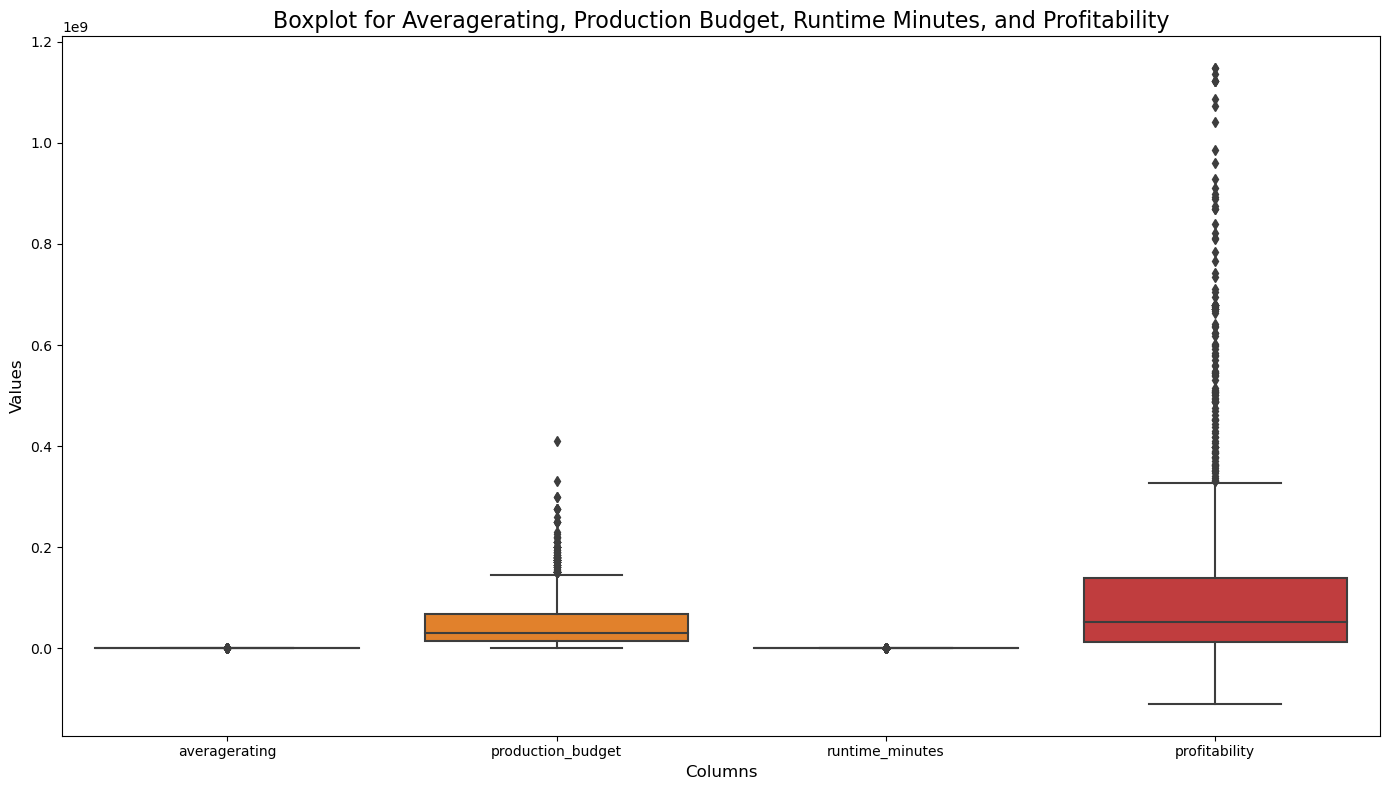

In [712]:
# Import the data files
gross_budget_df = pd.read_csv('cleaned_gross_budget.csv')
merged_data_df = pd.read_csv('cleaned_merged_data.csv')

#drop the release_date column from the merged_data_df
merged_data_df = merged_data_df.drop(['release_date'], axis=1)

# Merge the datasets on 'movie' and 'original_title', with 'cleaned_merged_data.csv' as the main table
df = pd.merge(merged_data_df, gross_budget_df, left_on='original_title', right_on='movie', how='left')

# add a profitability column
df["profitability"] = df["worldwide_gross"] - df["production_budget"]

# Checkicng for outliers
# Create a new DataFrame with the selected columns for the boxplot
columns_to_plot = ['averagerating', 'production_budget', 'runtime_minutes', 'profitability']

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create the boxplot using Seaborn
sns.boxplot(data=df[columns_to_plot])

# Add title and labels
plt.title('Boxplot for Averagerating, Production Budget, Runtime Minutes, and Profitability', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

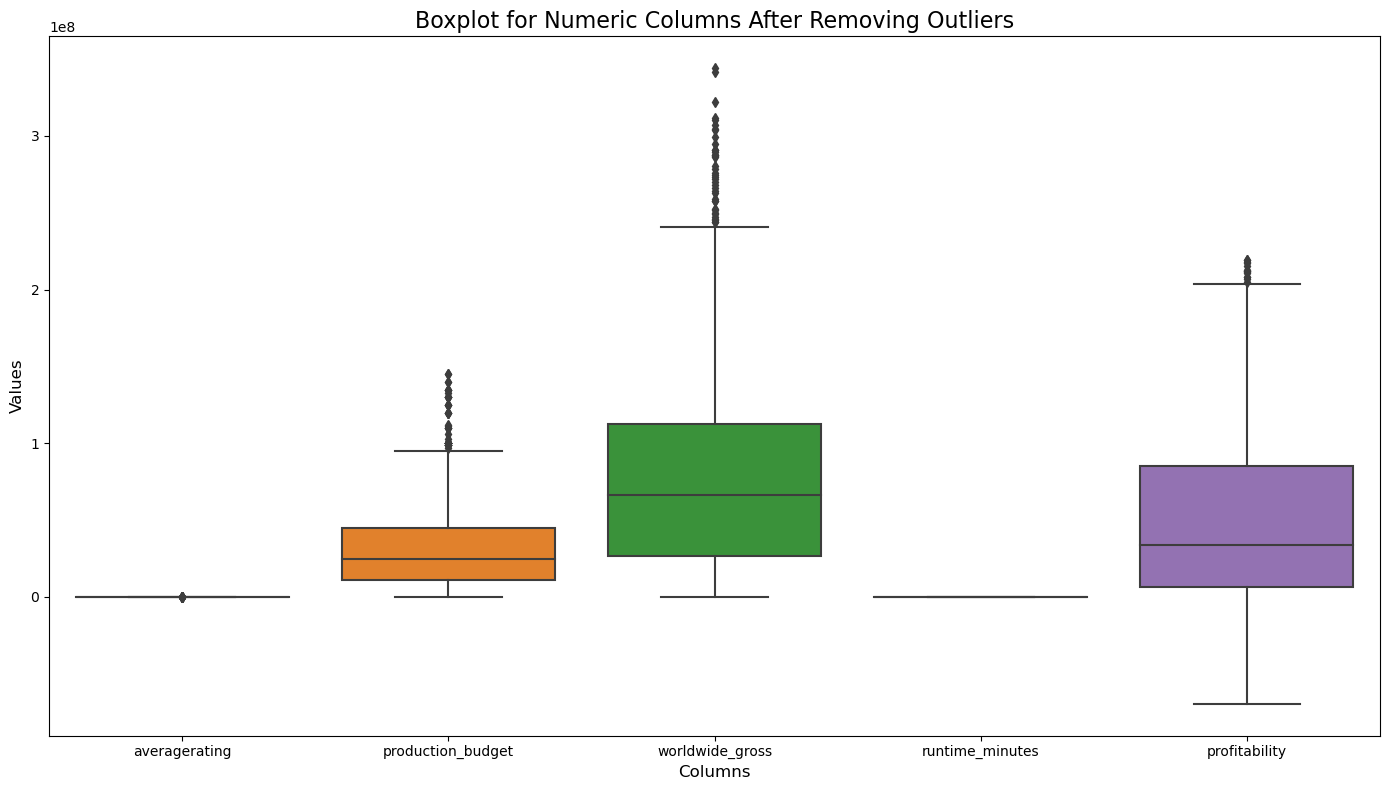

In [713]:
# Use a function to remove outlier from multiple relevant columns using IQR method
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from specified columns
numeric_columns = ['averagerating', 'production_budget', 'worldwide_gross', 'runtime_minutes', 'profitability']
df_cleaned = remove_outliers(df, numeric_columns)

# Define the numeric columns you want to plot
numeric_columns = ['averagerating', 'production_budget', 'worldwide_gross', 'runtime_minutes', 'profitability']

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create the boxplot using Seaborn
sns.boxplot(data=df_cleaned[numeric_columns])

# Add title and labels
plt.title('Boxplot for Numeric Columns After Removing Outliers', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [714]:
df_cleaned.dropna()

,original_language,original_title,popularity,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes,movie,studio,foreign_gross,release_date,production_budget,domestic_gross,worldwide_gross,profitability
7,en,Megamind,22.855,6.8,3635,95.0,"Action,Animation,Comedy",7.3,207488,Megamind,P/DW,173500000.0,11.0,130000000.0,148415853.0,321887208.0,191887208.0
12,en,The Expendables,21.517,6.1,4647,103.0,"Action,Adventure,Thriller",6.5,307897,The Expendables,LGF,171400000.0,8.0,82000000.0,103068524.0,268268174.0,186268174.0
14,en,Saw 3D,20.370,6.0,1488,90.0,"Crime,Horror,Mystery",5.6,83532,Saw 3D,LGF,90400000.0,10.0,17000000.0,45710178.0,133735284.0,116735284.0
16,en,The Book of Eli,18.985,6.7,3495,118.0,"Action,Adventure,Drama",6.9,271307,The Book of Eli,WB,62300000.0,1.0,80000000.0,94835059.0,158750817.0,78750817.0
17,en,Shutter Island,18.060,8.1,12625,138.0,"Mystery,Thriller",8.1,1005960,Shutter Island,Par.,166800000.0,2.0,80000000.0,128012934.0,299461782.0,219461782.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15162,en,"Paul, Apostle of Christ",12.005,7.1,98,108.0,"Adventure,Biography,Drama",6.7,5662,"Paul, Apostle of Christ",Affirm,5500000.0,3.0,5000000.0,17547999.0,25529498.0,20529498.0
15170,en,The 15:17 to Paris,11.576,5.3,799,94.0,"Biography,Drama,Thriller",5.2,21880,The 15:17 to Paris,WB,20800000.0,2.0,30000000.0,36276286.0,56096200.0,26096200.0
15191,en,Uncle Drew,10.836,6.5,220,103.0,"Comedy,Sport",5.7,9739,Uncle Drew,LG/S,4200000.0,6.0,18000000.0,42469946.0,46527161.0,28527161.0
15264,en,Proud Mary,9.371,5.5,259,89.0,"Action,Crime,Drama",4.9,6805,Proud Mary,SGem,876000.0,1.0,30000000.0,20868638.0,21709539.0,-8290461.0


In [715]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 962 entries, 7 to 15838
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_language  962 non-null    object 
 1   original_title     962 non-null    object 
 2   popularity         962 non-null    float64
 3   vote_average       962 non-null    float64
 4   vote_count         962 non-null    int64  
 5   runtime_minutes    962 non-null    float64
 6   genres             962 non-null    object 
 7   averagerating      962 non-null    float64
 8   numvotes           962 non-null    int64  
 9   movie              962 non-null    object 
 10  studio             962 non-null    object 
 11  foreign_gross      962 non-null    float64
 12  release_date       962 non-null    float64
 13  production_budget  962 non-null    float64
 14  domestic_gross     962 non-null    float64
 15  worldwide_gross    962 non-null    float64
 16  profitability      962 n

In [716]:
df_cleaned.to_csv('df_cleaned.csv', index=False)

# DATA ANALYSIS

## EXPLORATORY DATA ANALYSIS(EDA)
### What is the most popular and most highly rated genre?"

In [717]:
# Create an empty list to store individual genres
genres_list = []

# Split genres in each row and add them directly to genres_list
for genres in df_cleaned["genres"]:
    genres_list.extend(genres.split(','))

# Count the number of films by genre
genres_sum = Counter(genres_list)

# Calculate the total number of genre entries for percentage calculation
total_genres = sum(genres_sum.values())

# Create a DataFrame from the Counter, including percentage calculation
genre_df = pd.DataFrame(genres_sum.items(), columns=["Genre", "Count"])
genre_df["Percentage"] = (genre_df["Count"] / total_genres) * 100

# Sort the DataFrame by 'Count' in descending order
genre_df = genre_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

# Display the table
print(genre_df.head(5))
print(" ")
print("The Top five top watched movies are Drama, Comedy, Documentary, Thriller and Horror")

      Genre  Count  Percentage
0     Drama    499   21.045972
1    Comedy    327   13.791649
2    Action    234    9.869253
3  Thriller    207    8.730493
4     Crime    178    7.507381
 
The Top five top watched movies are Drama, Comedy, Documentary, Thriller and Horror


In [718]:
# Create a dictionary to store popularity totals and counts by genre
genre_popularity = defaultdict(lambda: {'total_popularity': 0, 'count': 0})

# Iterate through each row in the dataset
for index, row in df.iterrows():
    genres = row["genres"].split(',')
    popularity = row["popularity"]
    for genre in genres:
        genre_popularity[genre]['total_popularity'] += popularity
        genre_popularity[genre]['count'] += 1

# Calculate average popularity for each genre
average_popularity = {genre: data['total_popularity'] / data['count'] for genre, data in genre_popularity.items()}

# Convert the average popularity dictionary to a DataFrame for easy plotting
genre_popularity_df = pd.DataFrame(list(average_popularity.items()), columns=["Genre", "Average Popularity"])

# Sort the DataFrame by "Average Popularity" in descending order
genre_popularity_df = genre_popularity_df.sort_values(by="Average Popularity", ascending=False)
print(genre_popularity_df.head(5))

print(" ")
print("The most porpular genre are Adventure, Animation, Action, Fantansy and Crime")

        Genre  Average Popularity
0   Adventure            8.286318
4   Animation            7.729220
3      Action            7.072354
1     Fantasy            6.559962
10      Crime            5.556440
 
The most porpular genre are Adventure, Animation, Action, Fantansy and Crime


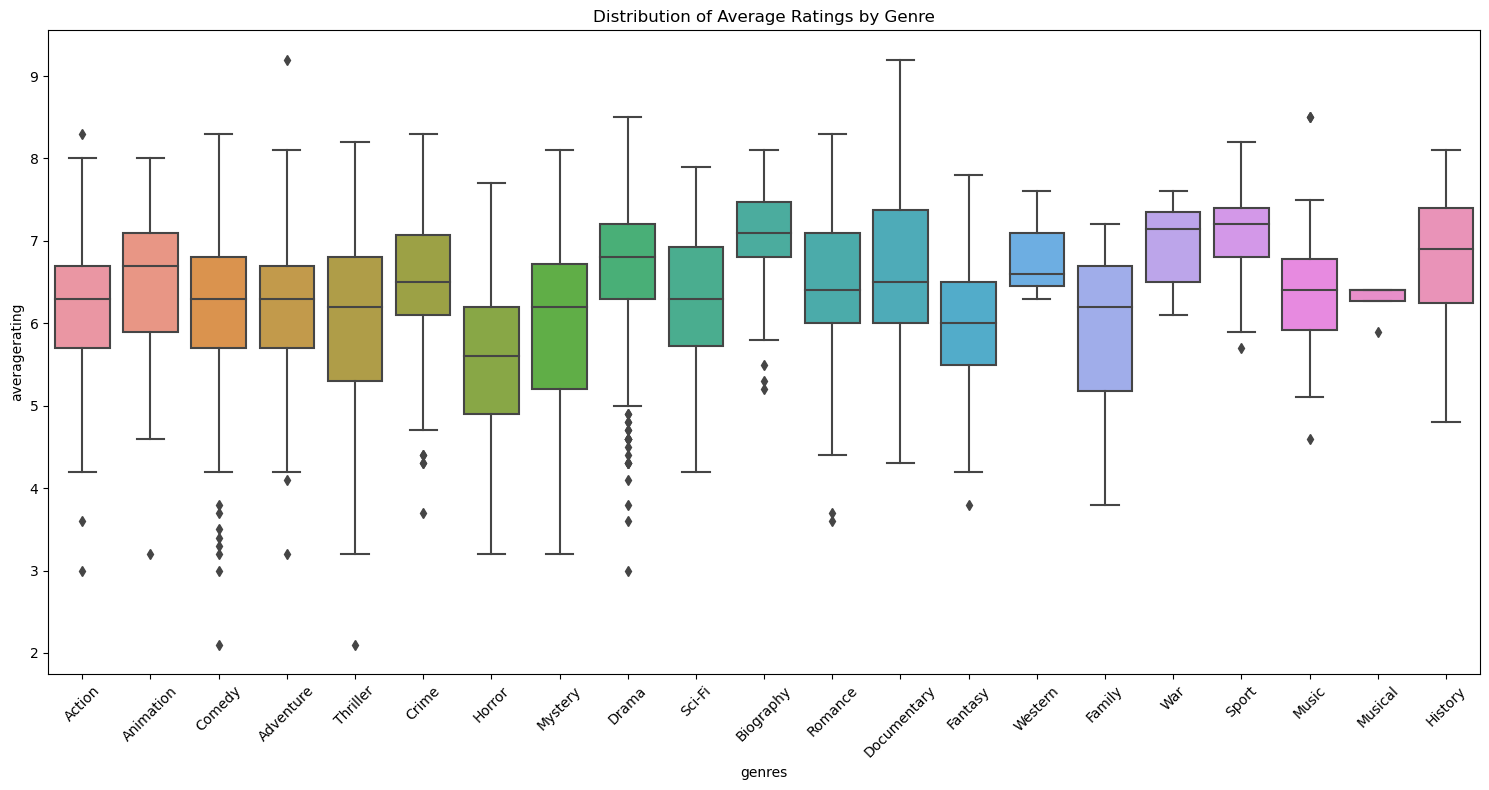

 
The Adventure genre has a median rating of around 6.
Fantasy has a median rating of about 5.5, which is slightly lower than Adventure.
Mystery has a median rating close to 6, similar to Adventure but with a tighter IQR


In [719]:
# Split genres and explode to analyze each genre separately
df_exploded = df_cleaned.assign(genres=df_cleaned['genres'].str.split(',')).explode('genres')
# Create plots for averagerating distribution by genre
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_exploded, x='genres', y='averagerating')
plt.xticks(rotation=45)
plt.title('Distribution of Average Ratings by Genre')
plt.tight_layout()
plt.show()

print(" ")
print("The Adventure genre has a median rating of around 6.")
print("Fantasy has a median rating of about 5.5, which is slightly lower than Adventure.")
print("Mystery has a median rating close to 6, similar to Adventure but with a tighter IQR")

### Is there a relationship between a movie's runtime and its user rating?

### How does production budget impact a movie's box office revenue?

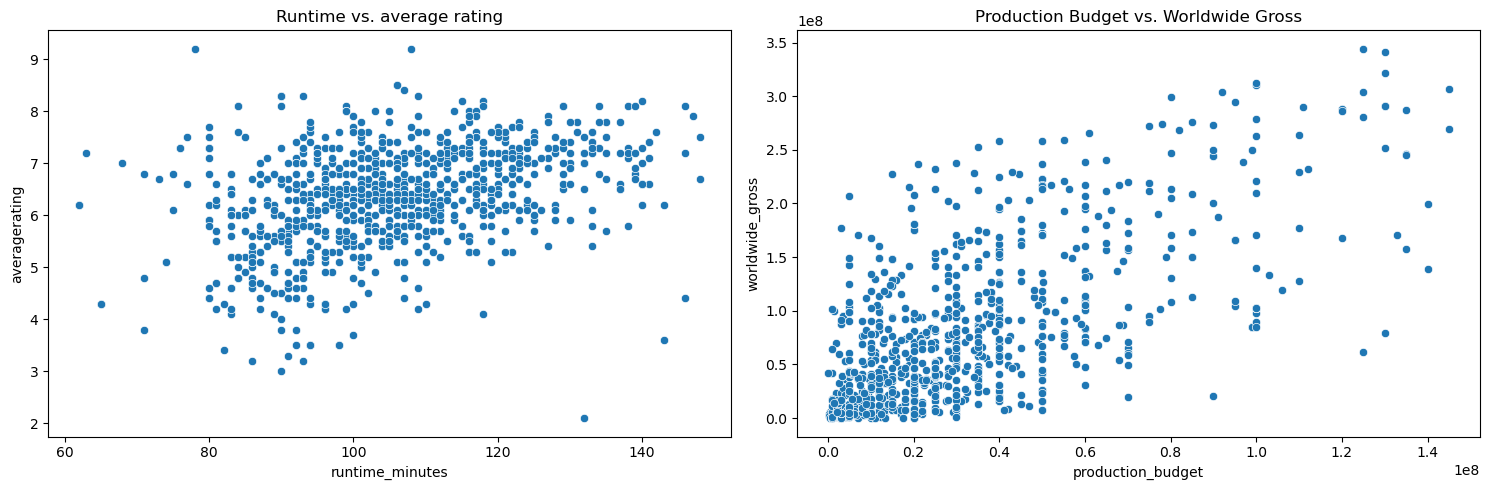

In [720]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# runtime vs vote_average
sns.scatterplot(data=df_cleaned, x='runtime_minutes', y='averagerating', ax=axes[0])
axes[0].set_title('Runtime vs. average rating')

# production_budget vs worldwide_gross
sns.scatterplot(data=df_cleaned, x='production_budget', y='worldwide_gross', ax=axes[1])
axes[1].set_title('Production Budget vs. Worldwide Gross')

plt.tight_layout()
plt.show()

#### - The scatter plots show a weak positive relationship between runtime_minutes and averagerating, indicating that movie runtime has little effect on user ratings, while production_budget and worldwide_gross exhibit a more noticeable positive trend, suggesting that higher budgets tend to correspond with higher box office revenues.

### Which types of films are profitable?

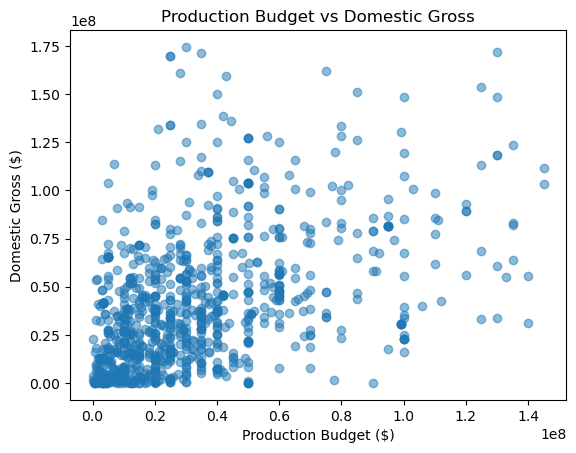

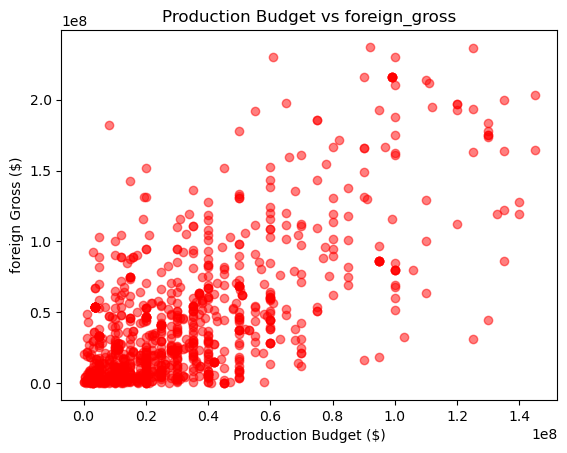

In [721]:
#How does the productions budget ralate to the domestic and worldwide gross revenue

import matplotlib.pyplot as plt

# Scatter plot for Production Budget vs Domestic Gross
plt.scatter(df_cleaned['production_budget'], df_cleaned['domestic_gross'], alpha=0.5)
plt.title('Production Budget vs Domestic Gross')
plt.xlabel('Production Budget ($)')
plt.ylabel('Domestic Gross ($)')
plt.show()

# Scatter plot for Production Budget vs Worldwide Gross
plt.scatter(df_cleaned['production_budget'], df_cleaned['foreign_gross'], alpha=0.5, color='r')
plt.title('Production Budget vs foreign_gross')
plt.xlabel('Production Budget ($)')
plt.ylabel('foreign Gross ($)')
plt.show()


 Both the domestic and foreign revenue scatter plots show a positive trend with the production budget. This suggests that, generally, movies with higher production budgets tend to generate higher revenues. However, the trend is not very strong, as points are widely scattered, indicating high variability.

In both plots, there is a dense cluster of points in the lower budget range. This indicates that many films with smaller budgets tend to have lower domestic and worldwide gross revenues.

### According to the release time, which months generate the highest profits?

In [722]:
# here we write a code that returns a Series with release_date as the index and the average profitability for each release date.
month_profit = df_cleaned.groupby('release_date')['profitability'].mean()
# covert month_profit into a DataFrame
monthly_profit_df = pd.DataFrame(month_profit)
monthly_profit_df.reset_index(drop=False, inplace=True)

# Descriptive Statistics
profit_description = monthly_profit_df['profitability'].describe()
print("Descriptive Statistics for 'profitability' column:")
print(profit_description)

Descriptive Statistics for 'profitability' column:
count    1.200000e+01
mean     5.006188e+07
std      7.183720e+06
min      4.068986e+07
25%      4.499408e+07
50%      4.933075e+07
75%      5.390091e+07
max      6.534814e+07
Name: profitability, dtype: float64


#### The descriptive statistics show that monthly profitability generally ranges between 40.7 million and 65.3 million, with an average of around 50 million. The relatively small standard deviation (compared to the mean) suggests that while there is some variation in monthly profits, most of the values are fairly close to the mean, indicating a moderately stable profitability over time.

In [723]:
monthly_profit_df.sort_values('profitability', ascending=False)

,release_date,profitability
6,7.0,6.534814e+07
10,11.0,5.728755e+07
11,12.0,5.492249e+07
1,2.0,5.356039e+07
5,6.0,5.240394e+07
9,10.0,5.043880e+07
3,4.0,4.822270e+07
0,1.0,4.777066e+07
7,8.0,4.582068e+07
8,9.0,4.251427e+07


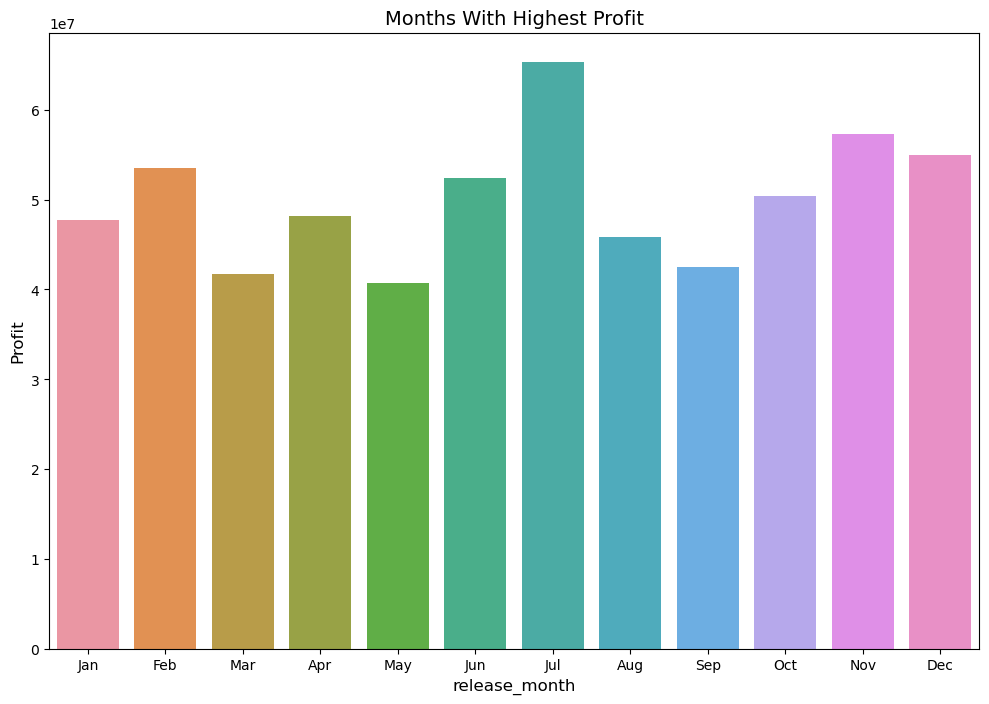

In [724]:
# Assuming 'monthly_profit_df' is a DataFrame with 'release_date' and 'profit' columns

fig, ax = plt.subplots(figsize=(12, 8))

# You can directly pass the DataFrame column names to sns.barplot using the 'x' and 'y' keyword arguments
sns.barplot(x='release_date', y='profitability', data=monthly_profit_df, ax=ax)

ax.set_title('Months With Highest Profit', fontsize=14)
ax.set_xlabel("release_month", fontsize=12)
ax.set_ylabel("Profit", fontsize=12)
ax.set_xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

fig.savefig('Months With Highest Profit.png')

#### from the above bar graph we can see the highest profits were made in July, November and December respectively. If we were to produce a film based on profitabilty, the top three months would be the best period to release it.

## STATISTICAL DISTRIBUTION

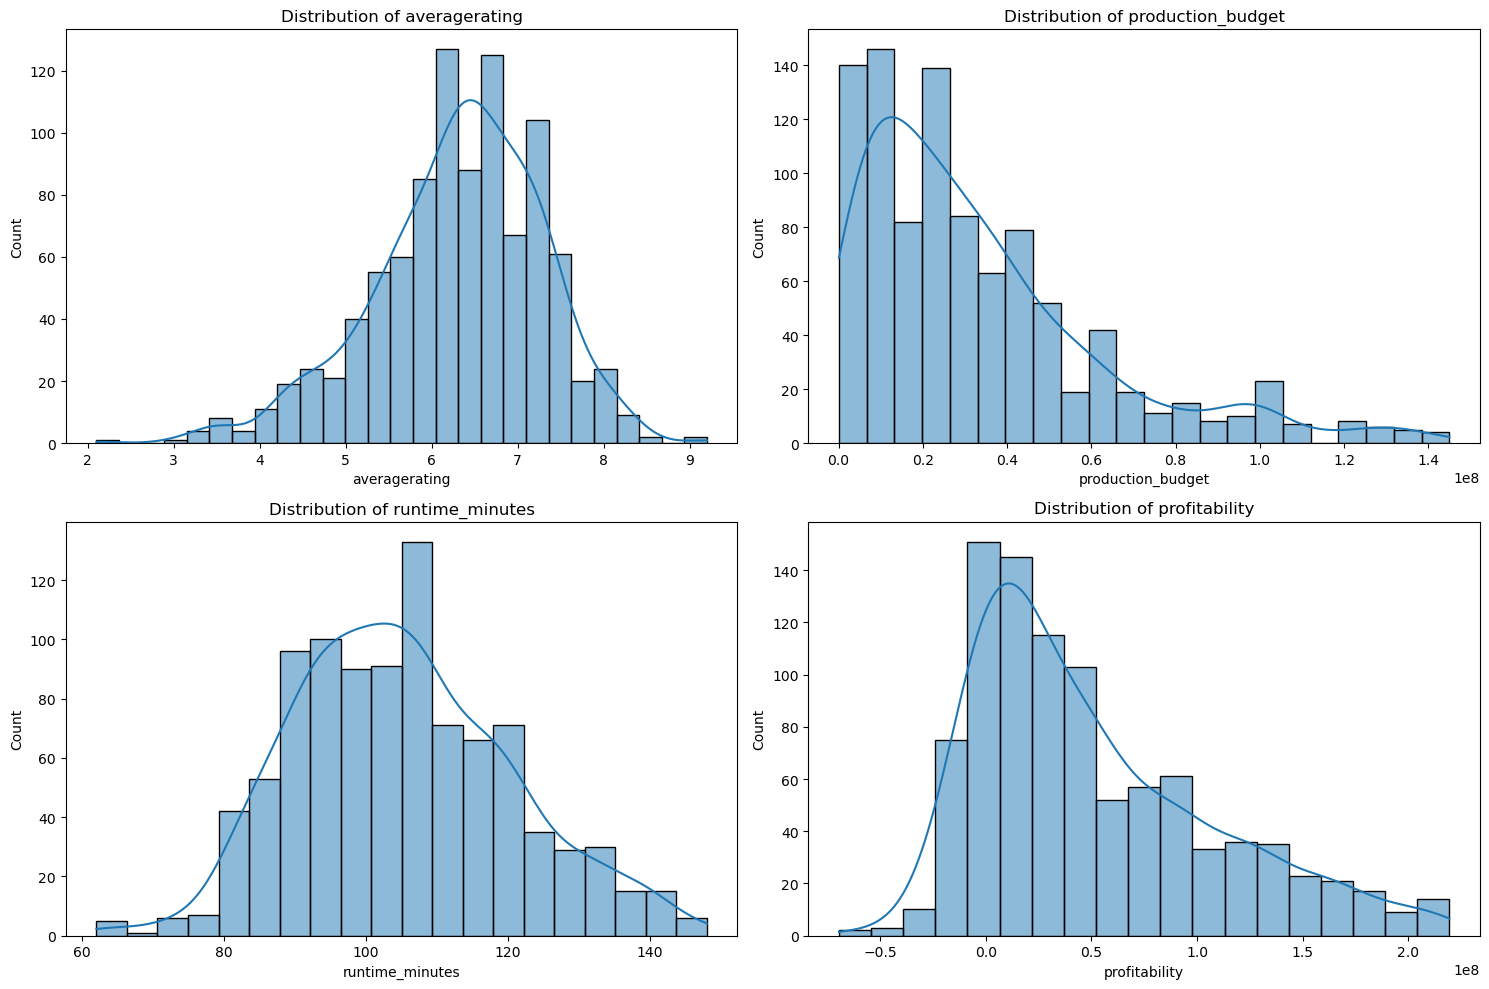

In [725]:
# Plot distributions
columns_to_plot = ['averagerating', 'production_budget', 'runtime_minutes', 'profitability']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(df_cleaned[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

##### Overall insight
The data appears to be normally distributed for average rating, production budget, and profitability, while runtime minutes are skewed right, with most movies falling between 90 and 120 minutes.

### Perform normality test using the Jarque-Bera Test

>> Jarque-Bera test for averagerating: Statistic=62.34226649562186, p-value=2.8976820942716586e-14
averagerating is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

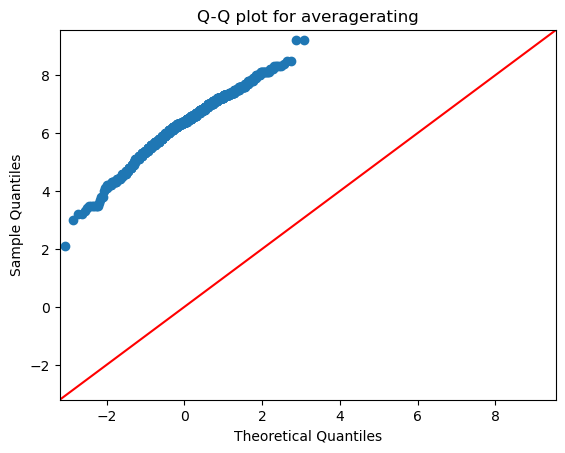

>> Jarque-Bera test for production_budget: Statistic=503.06752070827474, p-value=0.0
production_budget is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

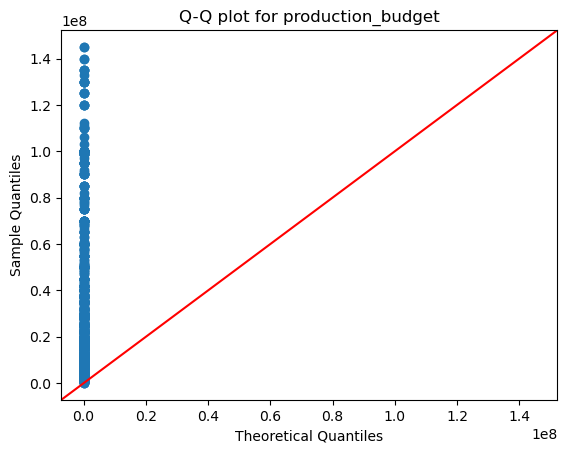

>> Jarque-Bera test for runtime_minutes: Statistic=16.78679346427127, p-value=0.00022635709662433
runtime_minutes is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

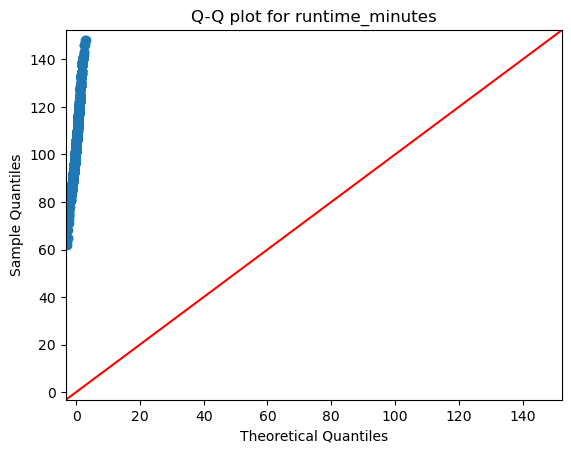

>> Jarque-Bera test for profitability: Statistic=138.6231712834969, p-value=0.0
profitability is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

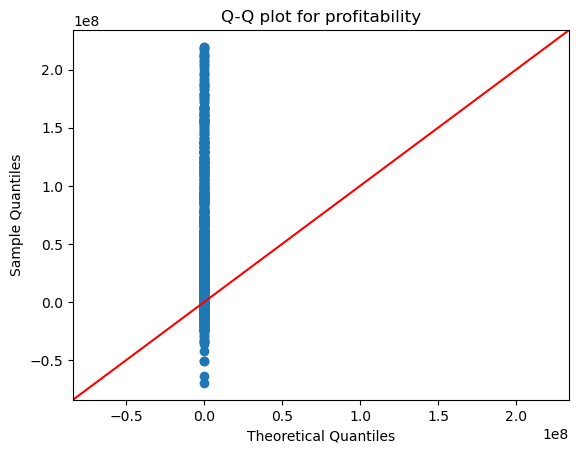

In [726]:
# List of columns to test for normality
columns_to_test = ['averagerating', 'production_budget', 'runtime_minutes', 'profitability']

# Testing for normality using the Jarque-Bera test
for col in columns_to_test:
    # Drop NaN values for the column
    data = df_cleaned[col].dropna()
    
    # Jarque-Bera Test
    jarque_bera_stat, jarque_bera_p_value = stats.jarque_bera(data)
    print(f'>> Jarque-Bera test for {col}: Statistic={jarque_bera_stat}, p-value={jarque_bera_p_value}')
    
    # Interpretation
    if jarque_bera_p_value < 0.05:
        print(f"{col} is likely not normally distributed (reject H0 at alpha=0.05).")
    else:
        print(f"{col} is likely normally distributed (fail to reject H0 at alpha=0.05).")
    
    # Visual Check: Q-Q Plot
    plt.figure(figsize=(6,6))
    sm.qqplot(data, line ='45')  # 45-degree reference line
    plt.title(f'Q-Q plot for {col}')
    plt.show()

### Normalize the columns using Log Transformations

In [727]:
# Assuming df_cleaned is your dataframe and columns to be normalized are mentioned
columns_to_transform = ['averagerating', 'production_budget', 'runtime_minutes', 'profitability']

# Define a function to apply Box-Cox (for positive values) or Yeo-Johnson (for mixed values)
def normalize_data(df, columns):
    normalized_data = pd.DataFrame()

    for col in columns:
        # Check if the column contains negative or zero values
        if (df[col] <= 0).any():
            # Use Yeo-Johnson transformation if there are non-positive values
            normalized_data[col], _ = stats.yeojohnson(df[col].dropna())
        else:
            # Use Box-Cox transformation for positive values
            normalized_data[col], _ = stats.boxcox(df[col].dropna())

    return normalized_data

# Apply the transformation
normalized_df = normalize_data(df_cleaned, columns_to_transform)

# Print out the first few rows of the transformed data
print(normalized_df.head())

   averagerating  production_budget  runtime_minutes  profitability
0      27.371940         607.070598         7.807683   1.053795e+08
1      21.522484         534.614570         8.028582   1.023946e+08
2      15.775154         346.065895         7.662129   6.517440e+07
3      24.359896         530.984340         8.408954   4.454556e+07
4      33.921093         530.984340         8.861246   1.199868e+08


### Display distribution after normalization

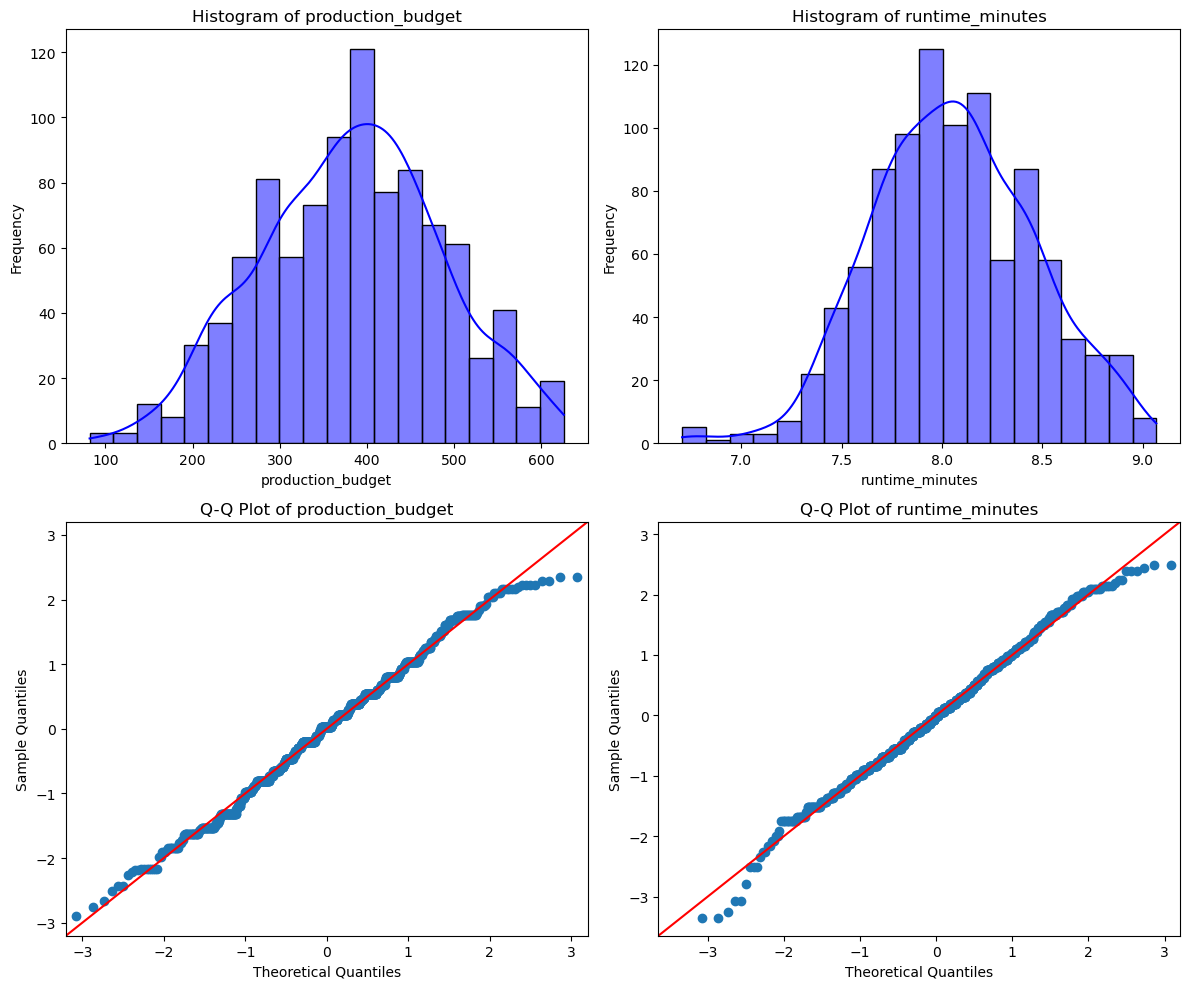

In [728]:
# Display the distributions in the normally distributed columns
# Select the columns that are likely normally distributed
normal_columns = ['production_budget', 'runtime_minutes']

# Set up plot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

# Plot histograms
for i, col in enumerate(normal_columns):
    # Histogram
    sns.histplot(normalized_df[col], bins=20, kde=True, color="blue", ax=axes[0, i])
    axes[0, i].set_title(f"Histogram of {col}")
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel("Frequency")

    # Q-Q Plot
    sm.graphics.qqplot(normalized_df[col], dist=stats.norm, line='45', fit=True, ax=axes[1, i])
    axes[1, i].set_title(f"Q-Q Plot of {col}")
    axes[1, i].set_xlabel("Theoretical Quantiles")
    axes[1, i].set_ylabel("Sample Quantiles")

# Adjust layout
fig.tight_layout()
plt.show()

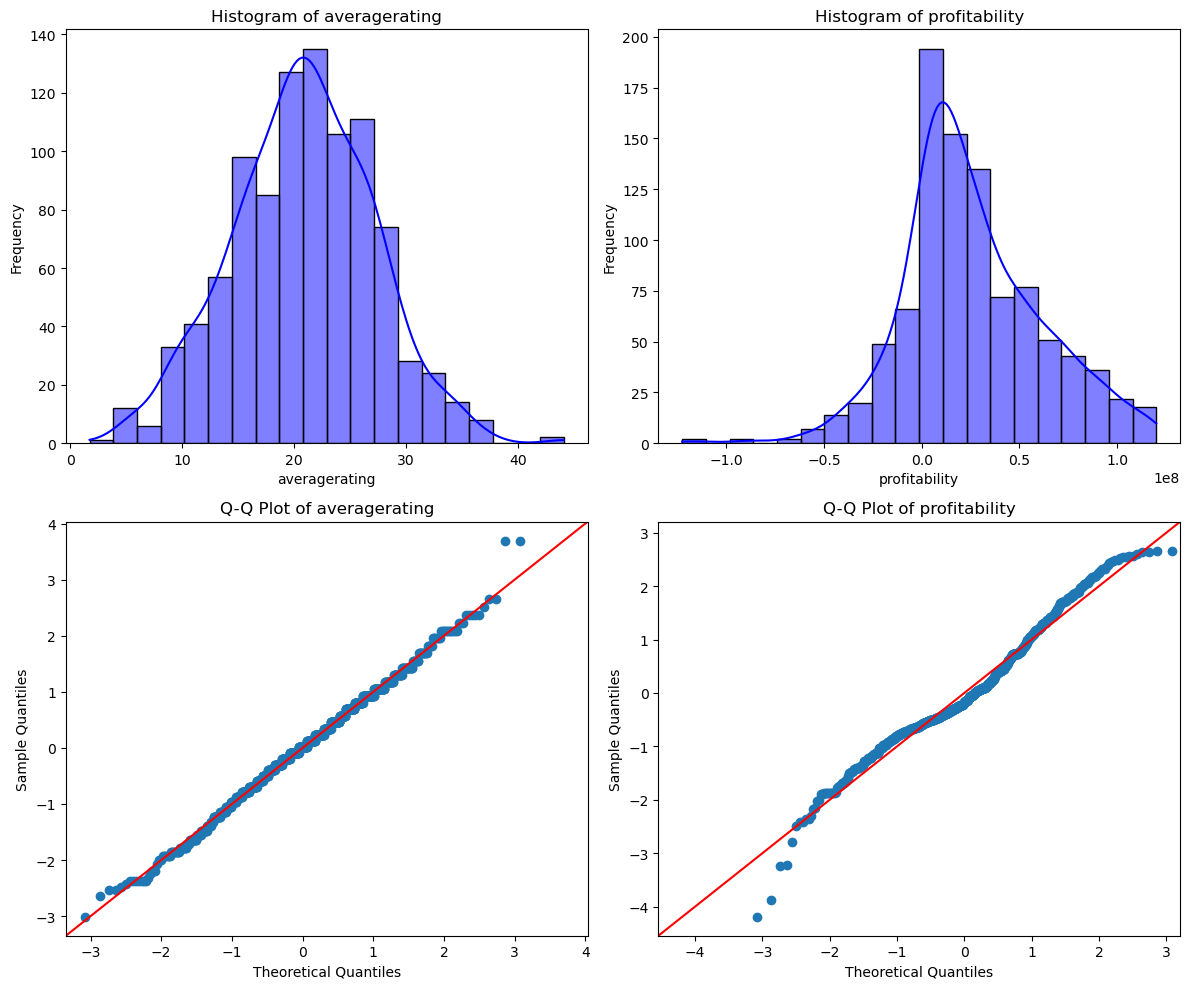

In [729]:
# Display the distributions in the normally distributed columns
# Select the columns that are likely normally distributed
normal_columns = ['averagerating', 'profitability']

# Set up plot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

# Plot histograms
for i, col in enumerate(normal_columns):
    # Histogram
    sns.histplot(normalized_df[col], bins=20, kde=True, color="blue", ax=axes[0, i])
    axes[0, i].set_title(f"Histogram of {col}")
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel("Frequency")

    # Q-Q Plot
    sm.graphics.qqplot(normalized_df[col], dist=stats.norm, line='45', fit=True, ax=axes[1, i])
    axes[1, i].set_title(f"Q-Q Plot of {col}")
    axes[1, i].set_xlabel("Theoretical Quantiles")
    axes[1, i].set_ylabel("Sample Quantiles")

# Adjust layout
fig.tight_layout()
plt.show()

## CORRELATION ANALYSIS

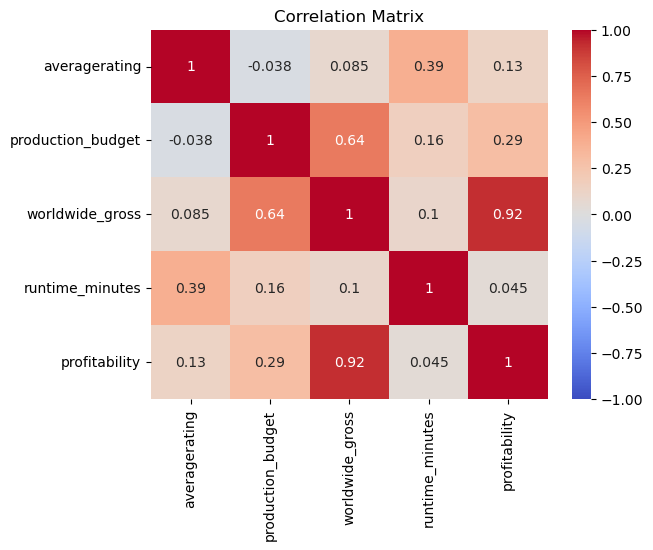

In [730]:
# Correlation matrix
corr_matrix = df_cleaned[['averagerating', 'production_budget', 'worldwide_gross','runtime_minutes', 'profitability']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows a strong positive relationship between production budget and worldwide gross, while profitability is moderately positively correlated with worldwide gross and average rating, and there are weak to no correlations between the remaining variables.

### Is the correlation between the produaction budget and worldwide gross statistically significant?

In [731]:
# Regress 'production_budget' against 'worldwide_gross'

# Prepare data for regression
X = df_cleaned['production_budget'].values  # Independent variable
y = df_cleaned['worldwide_gross'].values    # Dependent variable

# Perform linear regression using scipy's linregress
slope, intercept, r_value, p_value, std_err = linregress(X, y)

# Calculate R-squared from r_value
r_squared = r_value**2

# Output the results
print(f'R-squared: {r_squared}')
print(f'Coefficient (Slope): {slope}, Intercept: {intercept}')

R-squared: 0.4134423802254588
Coefficient (Slope): 1.572136385472121, Intercept: 31371869.385035284


- R-squared of 0.50, indicates that `production_budget` explains 50% of the variance in `worldwide_gross`, with a coefficient (slope) of 1.85 and an intercept of 19,705,776

In [732]:
#Hypothesis  Testing: Test if movie runtimes affect Production budget using a t-test.
# Split data by median runtime
median_runtime = df_cleaned['runtime_minutes'].median()
group1 = df_cleaned[df_cleaned['runtime_minutes'] <= median_runtime]['production_budget']
group2 = df_cleaned[df_cleaned['runtime_minutes'] > median_runtime]['production_budget']

# Perform t-test
t_stat, p_val = stats.ttest_ind(group1, group2)
print(f'T-test Statistic: {t_stat}, P-value: {p_val}')

T-test Statistic: -3.7573730754451677, P-value: 0.00018205761344963935
